## Transformer Training

Alex McDonald

In this jupyter notebook we will load the vocab and examples, then train a transformer on the spam and phishing URL examples. We will be using the GLoVE pre-trained embeddings, mostly to cut down on the amount of training needed for the rest of the transformer. 

In [12]:
import torch, torch.nn as nn
import numpy as np
import pandas as pd
import nltk
import math
import matplotlib.pyplot as plt

In [2]:
#Load the vocabulary space, adapted from Homework 2
glove_file = "./datasets/glove.6B.100d.txt" #or 50d

embeddings_dict = {}

with open(glove_file, 'r', encoding='utf8') as f:
    for i, line in enumerate(f):
        if i == 0:
            print(line)
        line = line.strip().split(' ')
        word = line[0]
        embed = np.asarray(line[1:], "float")

        embeddings_dict[word] = embed

print('Loaded {} words from glove'.format(len(embeddings_dict)))

embedding_matrix = np.zeros((len(embeddings_dict)+1, 100)) #add 1 for padding

word2id = {}
for i, word in enumerate(embeddings_dict.keys()):

    word2id[word] = i                                #Map each word to an index
    embedding_matrix[i] = embeddings_dict[word]      #That index holds the Glove embedding in the embedding matrix

# Our joint vocabulary for both models / sanity check to see if we've loaded it correctly:
print(word2id['the'])
print(embedding_matrix[word2id['the']])

word2id['<pad>'] = embedding_matrix.shape[0] - 1
print(embedding_matrix[word2id['<pad>']])

the -0.038194 -0.24487 0.72812 -0.39961 0.083172 0.043953 -0.39141 0.3344 -0.57545 0.087459 0.28787 -0.06731 0.30906 -0.26384 -0.13231 -0.20757 0.33395 -0.33848 -0.31743 -0.48336 0.1464 -0.37304 0.34577 0.052041 0.44946 -0.46971 0.02628 -0.54155 -0.15518 -0.14107 -0.039722 0.28277 0.14393 0.23464 -0.31021 0.086173 0.20397 0.52624 0.17164 -0.082378 -0.71787 -0.41531 0.20335 -0.12763 0.41367 0.55187 0.57908 -0.33477 -0.36559 -0.54857 -0.062892 0.26584 0.30205 0.99775 -0.80481 -3.0243 0.01254 -0.36942 2.2167 0.72201 -0.24978 0.92136 0.034514 0.46745 1.1079 -0.19358 -0.074575 0.23353 -0.052062 -0.22044 0.057162 -0.15806 -0.30798 -0.41625 0.37972 0.15006 -0.53212 -0.2055 -1.2526 0.071624 0.70565 0.49744 -0.42063 0.26148 -1.538 -0.30223 -0.073438 -0.28312 0.37104 -0.25217 0.016215 -0.017099 -0.38984 0.87424 -0.72569 -0.51058 -0.52028 -0.1459 0.8278 0.27062

Loaded 400000 words from glove
0
[-0.038194 -0.24487   0.72812  -0.39961   0.083172  0.043953 -0.39141
  0.3344   -0.57545   0.087459  0

For the URLs, we plan on pre-processing the string to split by characters such as "." or "/". We will likely need embeddings for things like ".com" or "https". First, we need to check if these embeddings already exist:

In [3]:
def embedding_exists(s):
    if not (s in word2id): return False
    if not (word2id[s] in embedding_matrix): return False
    return True

test_tokens = ["http", "https", ".com", "com", ".org", "org", ".net", "net"] #can add more, but likely that <unk> token will be frequent in the URL model
found = []
not_found = []
for token in test_tokens:
    if (embedding_exists(token)): 
        found.append(token)
    else: 
        not_found.append(token)

print("Found tokens %s" % found)
print("Could not find %s" % not_found)
        

Found tokens []
Could not find ['http', 'https', '.com', 'com', '.org', 'org', '.net', 'net']


It looks like there does not exist common url components in the Glove embeddings, so we will need to likely train our own embeddings for the URL model. This might give the model an advantage though, because patterns like "http" vs. "https" might help the model distinguish between different url types. Given how many different combinations of URLs can exist though (such as two words put together without any hyphenation) may still lead to a large number of $<unk>$ tokens, which will be another problem to address.

However, the GloVE embeddings should be adequate for the spam detection model. We will still need to be careful though, because the glove embeddings carry some amount of bias with them, which may become amplified by the model.

To save on computational resources, we will start with a smaller subset of the data, then increase it for the final training. Let's load the spam datasets:

In [9]:
spam_full = pd.read_csv("./datasets/SpamHam/train.csv", nrows=2000)

split_ratio = 0.8
train_size = int(split_ratio*spam_full.shape[0])
spam_train = spam_full.iloc[:train_size]
spam_valid = spam_full.iloc[train_size:]
max_length = 120

from nltk import word_tokenize

def tokenize_example(line):
    example = []
    tokenized = word_tokenize(line)
    i = 0
    for token in tokenized:
        if not (token in word2id): continue #not using <unk> for spam dataset
        i += 1
        if (i > max_length): break
        example.append(word2id[token])
        
    #add padding
    padding = word2id["<pad>"]
    for i in range(max_size - len(example)):
        example.append(padding)
    return np.array(example)

def tokenize(df):
    examples = []
    for index, row in df.iterrows():
        example = tokenize_example(row["text"])
        if (len(example) > 0 and len(example.shape) > 0): examples.append((example, row["label"]))
    return examples

tokenized_spam_train = tokenize(spam_train)
tokenized_spam_valid = tokenize(spam_valid)

Here we will create a simple pytorch transformer. A major limitation is the amount of computational power and time that we have to be able to train it, so our model will be smaller than the typical transformer. However, we are not using it like a typical transformer either, because its output space is a simple 'yes' or 'no,' so it is unlikely to need many parameters to begin with. We will start with an encoder model, but if it performs poorly we can try a decoder model.

In [40]:
class TransformerModel(nn.Module):

    def __init__(self, embedding_matrix, model_size, n_heads, n_layers, hidden_size, embedding_dims=100):
        super().__init__()

        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix))
        self.pos_encoding = PositionalEncoding(max_length)
        self.input_linear = nn.Linear(max_length + embedding_dims, model_size)
        encoder_layers = nn.TransformerEncoderLayer(model_size, n_heads, hidden_size)
        self.encoder = nn.TransformerEncoder(encoder_layers, n_layers)
        self.output_layer = nn.Linear(model_size, 2) #map to 'yes' or 'no'
        self.softmax = nn.Softmax()
        self.model_size = model_size


    def forward(self, input):

        #print("intput.shape: ", input.shape, len(input.shape))
        embedded = self.embedding(input) * math.sqrt(self.model_size) #recommended from documentation
        #print("embedding shape: ", embedded.shape)
        poe = self.pos_encoding(input).squeeze(1)
        #print("poe shape: ", poe.shape)
        input = torch.cat((embedded, poe), 1) #add positional encoding to input, need it per token
        #print("cat shape: ", input.shape)

        input = self.input_linear(input) #get a representation that has the model size for the positionally encoded embeddings
        #print("after input linear: ", input.shape)
        
        output = self.encoder(input)[-1] #take the last vector
        #print("after encoder: ", output.shape)
        output = self.output_layer(output)
        #print("after output linear: ", output.shape)
        output = self.softmax(output)

        return output

class PositionalEncoding(nn.Module):

    def __init__(self, model_size, max_len=5000): #from torch documentation
        super().__init__()
        self.dropout = nn.Dropout(p=0.1)
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, model_size, 2) * (-math.log(10000.0) / model_size))
        pe = torch.zeros(max_len, 1, model_size)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

And here we will define the training loop:

--- Epoch 1 --- 
epoch: 0 batch: 1 loss: 0.03933775186538696
epoch: 0 batch: 51 loss: 0.7276829242706299
epoch: 0 batch: 101 loss: 0.6809286111593247
epoch: 0 batch: 151 loss: 0.6708504658937454
epoch: 0 batch: 201 loss: 0.7368650126457215
epoch: 0 batch: 251 loss: 0.6868789601325989
epoch: 0 batch: 301 loss: 0.6721823161840439
epoch: 0 batch: 351 loss: 0.5970106148719787
epoch: 0 batch: 401 loss: 0.7065162110328674
epoch: 0 batch: 451 loss: 0.7059426510334015
epoch: 0 batch: 501 loss: 0.7092907154560089
epoch: 0 batch: 551 loss: 0.6587582802772523
epoch: 0 batch: 601 loss: 0.5527327984571457
epoch: 0 batch: 651 loss: 0.6936495363712311
epoch: 0 batch: 701 loss: 0.6607704389095307
epoch: 0 batch: 751 loss: 0.6509990948438644
epoch: 0 batch: 801 loss: 0.6932370072603226
epoch: 0 batch: 851 loss: 0.6856944197416306
epoch: 0 batch: 901 loss: 0.6230903381109237
epoch: 0 batch: 951 loss: 0.6808966642618179
epoch: 0 batch: 1001 loss: 0.6230281972885132
epoch: 0 batch: 1051 loss: 0.6931173723

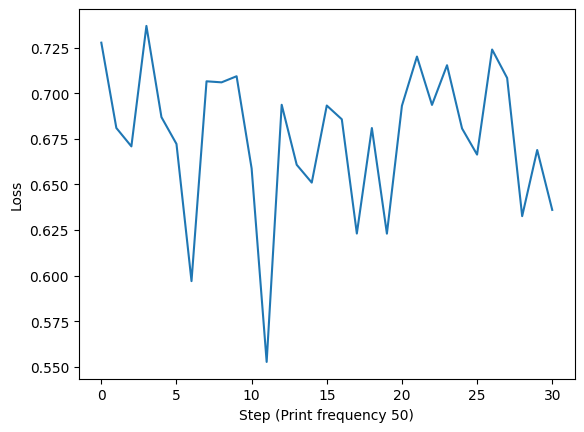

In [42]:

spam_model = TransformerModel(embedding_matrix, model_size=60, n_heads=2, n_layers=4, hidden_size=60)

import traceback
criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(spam_model.parameters())

epochs = 1
batch_size = 32
print_frequency = 50

spam_train_dataloader = torch.utils.data.DataLoader(tokenized_spam_train)
spam_valid_dataloader = torch.utils.data.DataLoader(tokenized_spam_valid)

one_hot = torch.tensor(np.array([[1, 0], [0, 1]]), dtype=torch.float)

losses = []
for i in range(epochs):
    print("--- Epoch %s --- " % (i+1))

    spam_model.train()
    avg_loss = 0

    for step, data in enumerate(spam_train_dataloader):
        x,y = data
        x = x.squeeze()
        if (len(x.shape) == 0): continue
        optimizer.zero_grad()

        output = spam_model(x)
        output = output.unsqueeze(0)
       # print("output:", output)
        #print("y:", one_hot[y])
        loss = criteria(output, one_hot[y])

        loss.backward()
        optimizer.step()

        avg_loss += loss.item()

        if step % print_frequency == 1:
            if (step > 1): losses.append(avg_loss / print_frequency)
            print('epoch: {} batch: {} loss: {}'.format(
                i,
                step,
                avg_loss / print_frequency
            ))
            avg_loss = 0

plt.plot(losses)
plt.xlabel("Step (Print frequency %s)" % print_frequency)
plt.ylabel("Loss")
plt.show()

In [6]:
#From Homework 3:
def predict(model, valid_dataloader):

    sigmoid = nn.Sigmoid()

    total_examples = 0 #len(valid_dataloader.dataset)
    total_true = 0
    total_false = 0

    true_positive = 0
    false_positive = 0
    true_negative = 0
    false_negative = 0

    i = 0

    for x, y in valid_dataloader:
        x = x.squeeze()
        if (len(x.shape) == 0): continue
        total_examples += 1
        output = model(x)
        
        i += 1
        print(output.shape, output, y)
        print(output)
        if (i > 10): return

        output = output.unsqueeze(0) #remove
        
        for i in range(output.shape[0]):
            if (output[i][0] < 0.5):
                if (y[0] == 0):
                    true_negative += 1
                    total_false += 1
                else:
                    false_negative += 1
                    total_true += 1
            else:
                if (y[0] == 0):
                    false_positive += 1
                    total_false += 1
                else:
                    true_positive += 1
                    total_true += 1

    accuracy = (true_positive + true_negative) / total_examples
    print('accuracy: {}'.format(accuracy))
    print('True positive: {}'.format(true_positive/total_true))
    print('True negative: {}'.format(true_negative/total_false))
    return accuracy

In [ ]:
predict(spam_model, spam_valid_dataloader)

torch.Size([2]) tensor([0.0110, 0.9890], grad_fn=<SoftmaxBackward0>) tensor([1])
tensor([0.0110, 0.9890], grad_fn=<SoftmaxBackward0>)
torch.Size([2]) tensor([0.0549, 0.9451], grad_fn=<SoftmaxBackward0>) tensor([0])
tensor([0.0549, 0.9451], grad_fn=<SoftmaxBackward0>)
torch.Size([2]) tensor([0.9940, 0.0060], grad_fn=<SoftmaxBackward0>) tensor([0])
tensor([0.9940, 0.0060], grad_fn=<SoftmaxBackward0>)
torch.Size([2]) tensor([0.9965, 0.0035], grad_fn=<SoftmaxBackward0>) tensor([0])
tensor([0.9965, 0.0035], grad_fn=<SoftmaxBackward0>)
torch.Size([2]) tensor([0.0195, 0.9805], grad_fn=<SoftmaxBackward0>) tensor([1])
tensor([0.0195, 0.9805], grad_fn=<SoftmaxBackward0>)
torch.Size([2]) tensor([0.0537, 0.9463], grad_fn=<SoftmaxBackward0>) tensor([1])
tensor([0.0537, 0.9463], grad_fn=<SoftmaxBackward0>)
torch.Size([2]) tensor([0.9965, 0.0035], grad_fn=<SoftmaxBackward0>) tensor([0])
tensor([0.9965, 0.0035], grad_fn=<SoftmaxBackward0>)
torch.Size([2]) tensor([0.0160, 0.9840], grad_fn=<SoftmaxBackw